In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [3]:
n_samples = 1000
x_temp = np.random.uniform(low=-10.0, high=40.0, size=n_samples)
x_sky = np.random.choice(['sunny', 'cloudy', 'rainy'], size=n_samples)
x_prec_prob = np.random.uniform(low=0.0, high=1.0, size=n_samples)
x_precip = np.random.uniform(low=0.0, high=10.0, size=n_samples)
x_humidity = np.random.uniform(low=0.0, high=100.0, size=n_samples)
x_wind_speed = np.random.uniform(low=0.0, high=20.0, size=n_samples)
y_solar_power = np.random.uniform(low=0.0, high=1000.0, size=n_samples)

x_temp_norm = (x_temp - np.mean(x_temp)) / np.std(x_temp)
x_prec_prob_norm = (x_prec_prob - np.mean(x_prec_prob)) / np.std(x_prec_prob)
x_precip_norm = (x_precip - np.mean(x_precip)) / np.std(x_precip)
x_humidity_norm = (x_humidity - np.mean(x_humidity)) / np.std(x_humidity)
x_wind_speed_norm = (x_wind_speed - np.mean(x_wind_speed)) / np.std(x_wind_speed)
y_solar_norm = (y_solar_power - np.mean(y_solar_power)) / np.std(y_solar_power)


In [4]:
y_tr = y_solar_norm[:700]
y_ts = y_solar_norm[700:]

In [5]:
sky = pd.DataFrame(x_sky)

In [6]:
sky = np.array(pd.get_dummies(sky).values)

In [7]:
x_data = np.concatenate([sky, x_temp_norm[:,np.newaxis], x_prec_prob_norm[:,np.newaxis], x_precip_norm[:,np.newaxis], x_humidity_norm[:,np.newaxis], x_wind_speed_norm[:,np.newaxis] ], axis = 1)

In [8]:
x_tr = x_data[:700]
x_ts = x_data[700:]

In [9]:
inputs = layers.Input(shape=(8,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [10]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=50, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=50, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

def custom_loss(model, inputs, outputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        loss = tf.reduce_mean(tf.square(predictions - outputs))

    grads = tape.gradient(loss, model.trainable_variables)

    boundary_x = tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
    boundary_y = tf.constant([[0.0], [0.0]])

    predictions_boundary = model(boundary_x)
    loss_boundary = tf.reduce_mean(tf.square(predictions_boundary - boundary_y))

    return loss + loss_boundary


In [11]:
input_dim = 8
output_dim = 1
model = PINN(input_dim, output_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
num_epochs = 5000

y_tr = y_tr.reshape(-1,1)
x_train = tf.convert_to_tensor(x_tr, dtype=tf.float32)

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = custom_loss(model, x_train, y_tr)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} Loss {loss.numpy():.4f}")


x_test = np.random.rand(1000, 6)
y_test = np.sin(np.sum(x_test, axis=1)).reshape(-1, 1)

predictions = model(x_ts)
mse = tf.reduce_mean(tf.square(predictions - y_ts))
print(f"Mean Squared Error: {mse.numpy():.4f}")


Epoch 0 Loss 1.2352
Epoch 500 Loss 0.6568
Epoch 1000 Loss 0.1477
Epoch 1500 Loss 0.0226
Epoch 2000 Loss 0.0039
Epoch 2500 Loss 0.0008
Epoch 3000 Loss 0.0002
Epoch 3500 Loss 0.0000
Epoch 4000 Loss 0.0032
Epoch 4500 Loss 0.0003
Mean Squared Error: 3.0270


In [12]:
# Predict on test set
preds = model.predict(x_ts)

# Calculate mean squared error
mse = np.mean((preds - y_ts)**2)

print('Mean Squared Error:', mse)

10/10 [==============================] - 0s 1ms/step
Mean Squared Error: 3.0269926870110586


plt.scatter(y_test, preds)
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

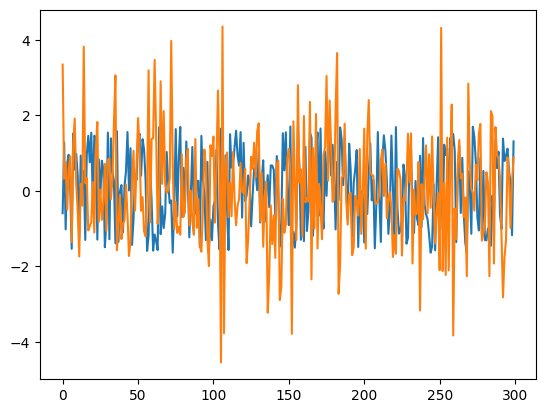

In [13]:
plt.plot(y_ts)
plt.plot(preds)

predicted_value = (max_value_norm + 1) / 2 * (max_value - min_value) + min_value

----

In [14]:
import tensorflow as tf
import numpy as np

def get_data():
    # Generate example data
    np.random.seed(123)
    X = np.random.randn(1000, 6)
    y = np.random.randn(1000, 1)
    return X, y

def physics_loss(pred_y, y, pred_dy_dx, X):
    # Define physics loss
    physics_loss = tf.reduce_mean(tf.square(pred_dy_dx + 0.5 * X[:,0:1] - X[:,1:2] * X[:,5:6] - X[:,3:4] + X[:,4:5] - pred_y))
    return physics_loss

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense = tf.keras.layers.Dense(64, activation='tanh')
        self.dense_1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.dense_1(x)
        return self.dense_2(x)



In [15]:
# Get example data
X, y = get_data()
X = tf.convert_to_tensor(X, dtype=tf.float32)

# Define model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam()

# Training loop
for i in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        pred_y = model(X)
        pred_dy_dx = tape.gradient(pred_y, X)
        loss = physics_loss(pred_y, y, pred_dy_dx, X)

    # Compute gradients and update variables
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Print loss every 100 iterations
    if i % 100 == 0:
        print(f"Loss at step {i}: {loss.numpy()}")


Loss at step 0: 4.34268045425415
Loss at step 100: 0.9844391942024231
Loss at step 200: 0.5773169994354248
Loss at step 300: 0.5245225429534912
Loss at step 400: 0.5059948563575745
Loss at step 500: 0.4957543909549713
Loss at step 600: 0.48844170570373535
Loss at step 700: 0.48217108845710754
Loss at step 800: 0.47602757811546326
Loss at step 900: 0.46995335817337036


----

In [ ]:
from math import *

In [16]:
Gsc,theta, tau, A, emiss, sigma, T = 1367

TypeError: cannot unpack non-iterable int object

In [ ]:
Q = (Gsc * cos(theta) * tau * A) + (emiss * sigma * A * ((T + 273.15) ** 4))

In [18]:
def clear_sky_model(T_air, GHI):
    """
    Compute the clear sky GHI based on the Linke turbidity factor model.

    Parameters:
        - T_air (float): air temperature in Celsius.
        - GHI (float): global horizontal irradiance in W/m^2.

    Returns:
        - GHI_clear (float): clear sky global horizontal irradiance in W/m^2.
    """
    # Convert temperature to Kelvin
    T = T_air + 273.15

    # Calculate optical air mass
    AM = 1 / (np.cos(np.radians(zenith_angle)) + 0.50572*(96.07995-zenith_angle)**(-1.6364))

    # Calculate extraterrestrial irradiance
    I_0 = 1367 * (1 + 0.033 * np.cos(2 * np.pi * doy / 365))

    # Calculate clear sky GHI
    GHI_clear = I_0 * np.exp(-0.0903 * AM**0.84 * (I_0 / GHI)**0.68 * ((T - 273.15 - 25) / 800)**3.0)

    return GHI_clear


In [19]:
def photovoltaic_equation(I_SC, I_L, V_OC, V_m, I, T_cell, N_s, N_p):
    """
    Compute the photovoltaic output power based on the single-diode model.

    Parameters:
        - I_SC (float): short-circuit current in amperes.
        - I_L (float): light-generated current in amperes.
        - V_OC (float): open-circuit voltage in volts.
        - V_m (float): voltage at the maximum power point in volts.
        - I (float): current in amperes.
        - T_cell (float): cell temperature in Celsius.
        - N_s (int): number of cells in series.
        - N_p (int): number of cells in parallel.

    Returns:
        - P_pv (float): photovoltaic output power in watts.
    """
    # Calculate cell temperature in Kelvin
    T = T_cell + 273.15

    # Calculate the diode ideality factor
    n = 1.1

    # Calculate the Boltzmann constant
    k = 1.38e-23

    # Calculate the electron charge
    q = 1.6e-19

    # Calculate the series resistance
    R_s = 0.01 * N_s

    # Calculate the shunt resistance
    R_sh = 100 * N_s

    # Calculate the saturation current
    I_0 = (I_SC + (I_L / (np.exp((q * V_OC) / (n * k * T)) - 1))) / (np.exp((q * V_OC) / (n * k * T)) - 1)

    # Calculate the current at the given voltage
    I_pv = I_L - I_0 * (np.exp((q * (N_s * V_m + I * R_s)) / (n * k * T)) - 1) - ((N_s * V_m + I * R_s) / R_sh)

    # Calculate the output power
    P_pv = I_pv * I

    return P_pv


In [21]:
inputs = tf.keras.Input(shape=(5,))
outputs = tf.keras.layers.Dense(1)(inputs)

# Define the model architecture
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function using the photovoltaic and clear sky models
def custom_loss(y_true, y_pred):
    # Extract the input variables
    temp, hum, wind_dir, wind_speed, sky_state = tf.unstack(y_true, axis=-1)
    
    # Calculate the solar irradiance using the clear sky model
    irradiance = clear_sky_model(latitude, longitude, day, time)
    
    # Calculate the cell temperature using the photovoltaic equation
    cell_temp = photovoltaic_equation(irradiance, temp)
    
    # Calculate the output power using the photovoltaic equation
    power = photovoltaic_equation(irradiance, cell_temp)
    
    # Calculate the predicted output power
    pred_power = y_pred
    
    # Calculate the loss as the mean squared error between the predicted and actual output power
    loss = tf.reduce_mean(tf.square(pred_power - power))
    
    return loss



In [ ]:
# Compile the model using the custom loss function
model.compile(optimizer='adam', loss=custom_loss)

# Generate example data
data = pd.DataFrame({
    'temperature': np.random.uniform(0, 50, size=100),
    'humidity': np.random.uniform(0, 100, size=100),
    'wind_dir': np.random.uniform(0, 360, size=100),
    'wind_speed': np.random.uniform(0, 20, size=100),
    'sky_state': np.random.choice([0, 1, 2, 3], size=100),
    'power': np.random.uniform(0, 1000, size=100)
})

In [22]:
# Train the model
X = data[['temperature', 'humidity', 'wind_dir', 'wind_speed', 'sky_state']]
y = data['power']


In [34]:
xx_train = X[:80]
yy_train = y[:80]

In [36]:
xx_train = tf.convert_to_tensor(x_train, dtype=tf.float32)

In [38]:
y = np.array(y).reshape(-1,1)

In [39]:
model.fit(xx_train, yy_train, epochs=200, batch_size=64, validation_split=0.1)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [43]:
def equation_of_time(day):
    """Compute the equation of time for a given day"""
    B = (day - 1) * (360 / 365)
    EoT = 229.18 * (0.000075 + 0.001868 * np.cos(np.radians(B)) - 0.032077 * np.sin(np.radians(B)) \
        - 0.014615 * np.cos(2 * np.radians(B)) - 0.040849 * np.sin(2 * np.radians(B)))
    return EoT

def clear_sky_index(zenith_angle):
    """Compute the clear sky index for a given zenith angle"""
    csi = 1.0 / (1 + (6.8 / (np.cos(zenith_angle) ** 0.75)))
    return csi

def extraterrestrial_radiation(day, latitude):
    """Compute the extraterrestrial radiation for a given day"""
    delta = 23.45 * np.sin(np.radians(360 * (284 + day) / 365))
    Gsc = 1367  # Solar constant
    dr = 1 + 0.033 * np.cos(np.radians(360 * day / 365))
    omega = np.arccos(-np.tan(np.radians(delta)) * np.tan(np.radians(23.45)))
    Ra = (24 * 60 / np.pi) * Gsc * dr * (omega * np.sin(np.radians(delta)) * np.sin(np.radians(latitude)) \
        + np.cos(np.radians(delta)) * np.cos(np.radians(latitude)) * np.sin(omega))
    return Ra

def clear_sky_model(latitude, longitude, day, time):
    # Convert inputs to radians
    lat_rad = np.radians(latitude)
    long_rad = np.radians(longitude)

    # Calculate declination angle
    B = (day - 1) * (360 / 365)
    declination = 23.45 * np.sin(np.radians(B))

    # Calculate solar noon time
    solar_noon = 12 + ((4 * long_rad) / np.pi) - (equation_of_time(day) / 60)

    # Calculate time correction factor
    tc = 60 * (time - solar_noon)

    # Calculate zenith angle
    zenith_angle = np.arccos(np.sin(lat_rad) * np.sin(declination) + np.cos(lat_rad) * np.cos(declination) * np.cos(np.radians(tc)))

    # Calculate clear sky radiation
    clear_sky_radiation = clear_sky_index(zenith_angle) * extraterrestrial_radiation(day, latitude) * 0.7

    return clear_sky_radiation


    
# Define photovoltaic equation
def photovoltaic_equation(T_air, GHI, clear_sky_radiation):
    # Define constants
    k = 1.38e-23  # Boltzmann constant
    q = 1.6e-19   # Electron charge
    Eg = 1.12     # Silicon bandgap energy
    A = 1         # Cell area

    # Calculate short-circuit current
    I_sc = (GHI / 1000) * A

    # Calculate open-circuit voltage
    T_ref = 25
    V_oc = ((k * (T_ref + 273.15)) / q) * np.log((I_sc / A) / ((q / k) * (T_air + 273.15)) + 1)

    # Calculate fill factor
    FF = 0.7

    # Calculate maximum power point current
    I_mpp = I_sc * FF

    # Calculate maximum power point voltage
    V_mpp = V_oc - (k * (T_ref + 273.15) / q) * np.log((I_mpp / A) / ((q / k) * (T_air + 273.15)) + 1)

    # Calculate power output
    P_out = I_mpp * V_mpp

    # Calculate efficiency
    eta = P_out / (GHI * A)

    # Calculate actual power output
    power_output = eta * clear_sky_radiation * A

    return power_output





In [40]:
# Create a virtual dataset
N = 1000
wind_directions = np.random.uniform(low=0, high=360, size=(N, 1))
wind_speeds = np.random.uniform(low=0, high=20, size=(N, 1))
temperatures = np.random.uniform(low=0, high=50, size=(N, 1))
humidities = np.random.uniform(low=0, high=100, size=(N, 1))
sky_conditions = np.random.uniform(low=0, high=1, size=(N, 1))
inputs = [wind_directions, wind_speeds, temperatures, humidities, sky_conditions]


In [57]:
import tensorflow as tf
import numpy as np

class PINN:
    def __init__(self, x, y):
        self.x = tf.Variable(x, dtype=tf.float32)
        self.y = tf.Variable(y, dtype=tf.float32)
        self.t = tf.Variable(tf.zeros_like(x), dtype=tf.float32)

        self.dt = tf.Variable(tf.ones_like(self.t), dtype=tf.float32)

        self.model = self.create_model()

    def create_model(self):
        # Define input layers
        X_input = tf.keras.layers.Input(shape=(1,), name='x_input')
        Y_input = tf.keras.layers.Input(shape=(1,), name='y_input')
        T_input = tf.keras.layers.Input(shape=(1,), name='t_input')
        dt_input = tf.keras.layers.Input(shape=(1,), name='dt_input')

        # Define the neural network
        H = tf.keras.layers.Concatenate()([X_input, Y_input, T_input, dt_input])
        H = tf.keras.layers.Dense(50, activation='tanh')(H)
        H = tf.keras.layers.Dense(50, activation='tanh')(H)
        H = tf.keras.layers.Dense(50, activation='tanh')(H)
        H = tf.keras.layers.Dense(50, activation='tanh')(H)
        H = tf.keras.layers.Dense(50, activation='tanh')(H)
        H = tf.keras.layers.Dense(50, activation='tanh')(H)

        # Define the output layer
        P_output = tf.keras.layers.Dense(1)(H)

        # Define the PINN model
        model = tf.keras.models.Model(inputs=[X_input, Y_input, T_input, dt_input], outputs=P_output)

        return model

    @tf.function
    def predict(self, x, y, t):
        # Predict the output of the PINN model at the given inputs
        return self.model([x, y, t, tf.ones_like(x)])

    @tf.function
    def train(self, epochs=5000, batch_size=128):
        optimizer = tf.keras.optimizers.Adam()

        for epoch in range(epochs):
            # Generate random batch
            idx = np.random.choice(self.x.shape[0], batch_size, replace=False)
            x_batch = tf.gather(self.x, idx)
            y_batch = tf.gather(self.y, idx)
            t_batch = tf.gather(self.t, idx)
            dt_batch = tf.gather(self.dt, idx)

            # Define the loss function
            with tf.GradientTape(persistent=True) as tape:
                P_pred = self.predict(x_batch, y_batch, t_batch)
                dP_dt = tf.gradients(P_pred, t_batch)
                dP_dx = tf.gradients(P_pred, x_batch)
                dP_dy = tf.gradients(P_pred, y_batch)

                # Compute the partial derivatives of the input variables
                d2P_dx2 = tf.gradients(dP_dx, x_batch)
                d2P_dy2 = tf.gradients(dP_dy, y_batch)

                # Compute the loss function
                loss = tf.reduce_mean(tf.square(dP_dt + 2 * (d2P_dx2 + d2P_dy2)))

            # Compute the gradients and update the variables
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            # Print the loss every 100 epochs
            if epoch % 100 == 0:
                print("Epoch: {} Loss: {}".format(epoch, loss))



In [58]:
N = 1000
wind_directions = np.random.uniform(low=0, high=360, size=(N, 1))
wind_speeds = np.random.uniform(low=0, high=20, size=(N, 1))
temperatures = np.random.uniform(low=0, high=50, size=(N, 1))
humidities = np.random.uniform(low=0, high=100, size=(N, 1))
sky_conditions = np.random.uniform(low=0, high=1, size=(N, 1))

inputs = np.concatenate([wind_directions, wind_speeds, temperatures, humidities, sky_conditions], axis=1)
inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
pinn_model = PINN(inputs[:, :2], inputs[:, 2])


In [68]:
pinn_model = PINN(inputs, inputs)

In [67]:
pinn_model.train(epochs=10000, batch_size=256)


ValueError: in user code:

    File "C:\Users\user\AppData\Local\Temp\ipykernel_3132\2695135045.py", line 57, in train  *
        P_pred = self.predict(x_batch, y_batch, t_batch)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_3132\3681396726.py", line 41, in predict  *
        return self.model([x, y, t, tf.ones_like(x)])
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_7' (type Functional).
    
    Input 0 of layer "dense_51" is incompatible with the layer: expected axis -1 of input shape to have value 4, but received input with shape (256, 20)
    
    Call arguments received by layer 'model_7' (type Functional):
      • inputs=['tf.Tensor(shape=(256, 5), dtype=float32)', 'tf.Tensor(shape=(256, 5), dtype=float32)', 'tf.Tensor(shape=(256, 5), dtype=float32)', 'tf.Tensor(shape=(256, 5), dtype=float32)']
      • training=None
      • mask=None
